# MLP

## Setup

In [21]:
import os
import sys
import importlib

LIB_DIR = './lib'
SAVED_MODELS_DIR = '../backend/saved_models'

os.makedirs(LIB_DIR, exist_ok=True)
sys.path.append(LIB_DIR)
os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
sys.path.append(SAVED_MODELS_DIR)

def install_package(package_name):
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed")
    except ImportError:
        print(f"Installing {package_name}")
        %pip install --quiet $package_name --progress-bar on

def download_lib(filename, url):
    LIB_PATH = os.path.join(LIB_DIR, filename)
    if not os.path.exists(LIB_PATH):
        print(f"Downloading {filename}")
        import urllib.request
        urllib.request.urlretrieve(url, LIB_PATH)
        print(f"Downloaded {filename} to {LIB_PATH}")
    else:
        print(f"{filename} already downloaded")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import joblib

download_lib("visualization.py", "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py")

import visualization # type: ignore
from visualization import plot_conf_mat # type: ignore
importlib.reload(visualization)

from lib.utils import make_serializable

visualization.py already downloaded


In [9]:
files_path = ''

if 'google.colab' in str(get_ipython()): # type: ignore
    print('TO DO: Set up Google Colab')
    # print('Running in Google Colab')
    # from google.colab import drive
    # mount_point = '/content/drive'
    # drive.mount(mount_point)
    # files_path = mount_point + '/MyDrive/Colab Notebooks/'
else:
    print('Running locally')
    files_path = '../data/'

Running locally


In [10]:
german_df = pd.read_csv(files_path + 'syntetic_sample.csv')

In [11]:
mappings = {
    'sex': {
        'female': 0,
        'male': 1
    },
    'present_employee_since': {
        'unemployed': 0, '<1y': 1, '1-4y': 2, '4-7y': 3, '>=7y': 4
    },
    'checking_account': {
        'no checking account': 0, '< 0 DM': 1, '0 <= ... < 200 DM': 2, '>= 200 DM': 3
    },
    'savings': {
        '0 or unk.': 0, '<100 DM': 1, '100-500 DM': 2, '500-1000 DM': 3, '>1000 DM': 4
    },
    'job': {
        'unemployed/unskilled non-resident': 0,
        'unskilled resident': 1,
        'qualified': 2,
        'highly qualified': 3
    }
}

german_preprocessed_df = german_df.copy()

for col, mapping in mappings.items():
    german_preprocessed_df[col] = german_preprocessed_df[col].map(mapping).astype(int)

In [12]:
german_dummies_df = pd.get_dummies(german_preprocessed_df, dtype=int, drop_first=True)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    german_dummies_df.drop(columns=['risk']),
    german_dummies_df['risk'],
    test_size=0.2,
    random_state=42
)

In [14]:
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            activation='relu',
            alpha=0.001,
            hidden_layer_sizes=(128, 64, 32),
            learning_rate_init=0.01,
            max_iter=200,
            early_stopping=True,
            random_state=42
        ))
    ])


pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=0.001, early_stopping=True,
                               hidden_layer_sizes=(128, 64, 32),
                               learning_rate_init=0.01, random_state=42))])

In [15]:
pipeline.predict_proba(x_test)

array([[0.0241285 , 0.9758715 ],
       [0.0667305 , 0.9332695 ],
       [0.98419775, 0.01580225],
       ...,
       [0.00239446, 0.99760554],
       [0.44319066, 0.55680934],
       [0.51393596, 0.48606404]], shape=(200000, 2))

In [16]:
y_pred = pipeline.predict(x_test)
y_pred

array([1, 1, 0, ..., 1, 1, 0], shape=(200000,))

In [17]:
class_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     60005
           1       0.92      0.94      0.93    139995

    accuracy                           0.90    200000
   macro avg       0.88      0.88      0.88    200000
weighted avg       0.90      0.90      0.90    200000



Normalized confusion matrix
[[0.81701525 0.18298475]
 [0.06410229 0.93589771]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

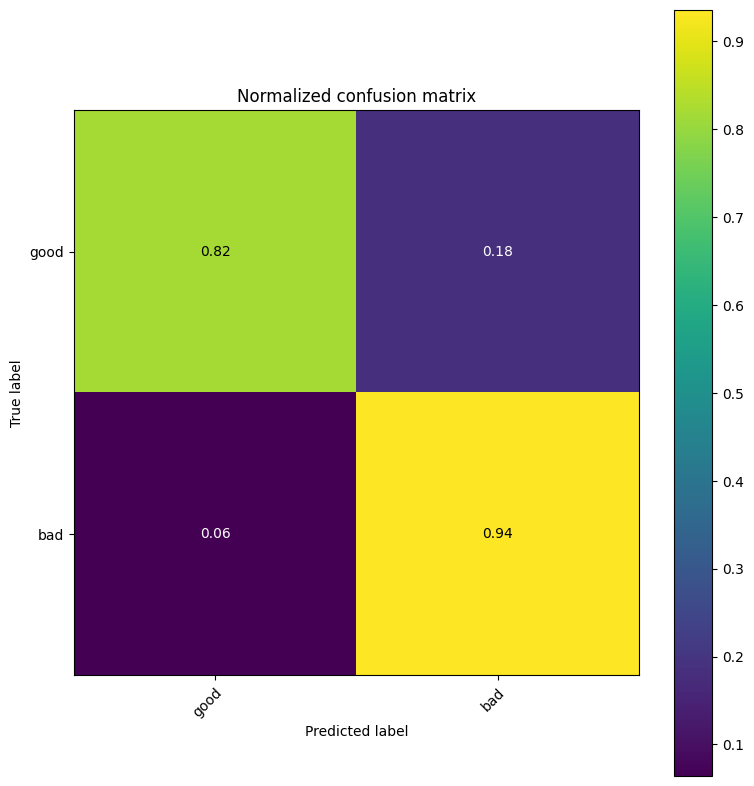

In [18]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = np.array(['good', 'bad'])
plot_conf_mat(y_test, y_pred, class_names)

In [22]:
metrics = {
    "confusion_matrix": cm_normalized,
    "classification_report": class_report,
}
joblib.dump({"model": pipeline, "metrics": make_serializable(metrics),}, SAVED_MODELS_DIR + '/mlp.pkl')

['../backend/saved_models/mlp.pkl']